## 10_Met_v0.1_results

This notebook contains the generation of the result section for the methodology developed as part of the LandGriffon platform. Link here: https://docs.google.com/document/d/1s1rINj-YVDQ36Vu-Q3T1sc55hcVLROJclaaELRF9tck/edit#

The idea would be to compute deforestation in three different location types using satelligence data. The location types to be enalysed are:

    - Point of production (selection of a palm oill mill)
    - Agrregation point (50km radius buffer arund that palm oil mill)
    - Administrative area (Aceh in our case)

NOTE: country of production cannot be performed as we are issing this coverege with Satelligence data. We can potentially cover this for a different indicator (e.g. water footprint)

    
Datasets needed:

    - palm oil mill locataions
    - deforetation datasets (satelligence)
    - gadm boundaries
    



In [4]:
# import libraries
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio as rio

!pip install h3ronpy h3pandas --q
from h3ronpy import raster
import h3
import h3pandas
import pandas as pd
from shapely.geometry import Polygon

import os

In [5]:
import numpy as np
from PIL import Image
import scipy.ndimage
import scipy.signal
from osgeo import gdal

In [6]:
def buffer_stats(raster_path, vector_path, buffer=50000, stat_='sum', all_touched = True):
    """
    inputs:
    -------------
    raster_path: raster path for retriving the statisticts in EPSG:4326
    vector_path: path to point file in EPSG:4326
    buffer: distance in metres for coputing the buffer
    stats: stadistics to compute
    
    output
    -------
    array with statistics"""
    
    #open vector file
    gdf = gpd.read_file(vector_path)
    #check projection
    #if gdf.crs != True:
    #    print(gdf.crs)
    #    #project
    #    print('Dataset missing projection. Please assign one!')
    if gdf.crs and gdf.crs == 'EPSG:4326':
        #reproject
        gdf_3857 = gdf.to_crs('EPSG:3857')
    ## TODO:add other validations
    

    #get buffer
    gdf_3857_buffer = gdf_3857.buffer(buffer)
    #reproject back to epsg4326
    gdf_4326_buffer = gdf_3857_buffer.to_crs('EPSG:4326')
    #get statistics
    vizz_stats = []
    for geom in gdf_4326_buffer:
        stats = zonal_stats(geom,
                    raster_path,
                    stats=stat_,
                    all_touched = all_touched
            )
        stat_sum = stats[0]['sum']
        vizz_stats.append(stat_sum)
    #add stats in dataframe
    gdf['estimated']=vizz_stats
    return gdf

def raster_to_h3(raster_path, resolution=6, field='value', plot=False):
    """convert raster to h3 with a given h3 resolution. Returns a gdf with the h3 geometries."""
    
    with rio.open(raster_path) as src:
        gdf = raster.raster_to_geodataframe(src.read(1), src.transform, h3_resolution=resolution, nodata_value=src.profile['nodata'], compacted=False)

    gdf = gdf.rename(columns={'value':field})
    if plot:
        gdf.plot(field)
    gdf['h3index'] = gdf['h3index'].apply(hex)
    
    return gdf
    
    
def focal_mean(raster_path, 
               kernel_path, 
               output_path):
    #open deforestation array
    ds_def = gdal.Open(raster_path)
    def_array = np.array(ds_def.GetRasterBand(1).ReadAsArray())
    
    #open kernel path
    ds_kernnel = gdal.Open(kernel_path)
    kernnel_array = np.array(ds_kernnel.GetRasterBand(1).ReadAsArray())
    
    #perform the focal mean with convolute
    result_fm = scipy.ndimage.convolve(def_array, weights=kernnel_array) / kernnel_array.size
    im = Image.fromarray(result_fm)
    im.save(output_path)
    
    

## 1. Generate h3 dataset from raster

ingets data as density - This values would need to be multiplied by the hex area in the analysis:


 - 1. multiplies by 1 and remove no data values.
 - 2. downsample to the same resolution used for the otehr datasets ingested using the sum resampling method
 - 3. divides the sum by the total sum in each pixel to get the density
 - 4. Translate to h3
 - 5. Get pixel area ratio


In [7]:
!gdal_calc.py --calc "A*1" --format GTiff --type Float32 --NoDataValue 0.0 -A ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01.tif --A_band 1 --outfile ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif;
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:4326 -dstnodata 0.0 -tr 0.0833333333333286 0.0833333333333286 -r sum  -multi -of GTiff ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_mask.tif ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_sum.tif
!gdal_calc.py --calc "A/1929012.345678793" --format GTiff --type Float32 --NoDataValue 0.0 -A ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_sum.tif --A_band 1 --outfile ../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_density.tif

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 

48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 49.. 

71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 

94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 95.. 96.. 96.. 96.. 96.. 

### Sanity check:

Check deforestation computed by satelligence in the different mill versus the one that we obtained using the h3 data ingestion:

In [30]:
# get deforestation in buffer zones

vector_path = '../../datasets/processed/Satelligence_data/test_rasters_2/satelligence_mills_4326_50kmbuffer.shp'
resolution = 6

gdf_vector = gpd.read_file(vector_path)
clean_gdf = gdf_vector[['gfw_fid','deforestat','geometry']]

_sum_calculated = []
for i, row in clean_gdf.iterrows():
    filtered_gdf = clean_gdf[i:i+1]
    #convert to h3
    h3_gdf = filtered_gdf.h3.polyfill_resample(resolution)
    h3index_list = [f'0x{h3index}' for h3index in h3_gdf.index]
    _sum = merge_gdf[merge_gdf['h3index'].isin(h3index_list)]['deforestation_km2'].sum()*100
    _sum_calculated.append(_sum)
    
#_sum_calculated

In [14]:
#zonal statistics raster
stats_ = buffer_stats('../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01.tif',
                      '../../datasets/processed/palm_oil_mills/satelligence_mills_4326_point.shp',
                      buffer=50000,
                      stat_='sum', all_touched = False)

In [21]:
def_raster = list(stats_['estimated']*6.69019042035408517*6.69019042035408517* 0.0001)

## 2. Kernel landscale-level impact

Based on the LandGriffon v0.1 methodology, for the calculation of the forest loss risk , he production map is buffered using a radius kernel prior to using ir as the weighted layer, in order to capture areas nearby to production regions. The impact factor is calculated as the production weighted average within the sourcing geometry using the buffered production map.

This is not applied for the land impact calculation performed previously. 

The formula applied for the forest loss impact is:


I c,g = IFgb * I farm-land c,g / sum(Harvest area)


Where IFgb is the impact factor associated with the buffered sourcing geometry gb; and,  is the harvested area (ha) of crop cr in the buffered sourcing location gb. 

IFgb = kernnel Deforestation layer weighted by the production layer
Harvest area of all mapspam commodities


IFgb = Def - pixel * Prod - pixel / sumProd Area



- apply kernel to deforestation raster
- calculate deforestation file sum( def * prod) / total prod

- def_impact * land_impact / harvest area all commodities

### 1: Generate deforestation kernel 50km


In [77]:
# ultiply def area in hectares
# then filter all locations where there is production

def_density = '../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_density.tif'
def_area_ha = '../../datasets/raw/methodology_results/update/Deforestation_IDN_2021-01-01-2022-01-01_area_ha.tif'
kernel_50km = '../../datasets/raw/methodology_results/test_location_buffer_raster.tif'

# pixel area in hectares = 8633.766614450342  
#calculate deforestation area
!gdal_calc.py --calc "A*8633.766614450342" --format GTiff --type Float32 --NoDataValue 0.0 -A $def_density --A_band 1 --outfile $def_area_ha;


## generate kernel
focal_mean(raster_path = def_area_ha, 
               kernel_path = kernel_50km, 
               output_path = '../../datasets/raw/methodology_results/update/deforestation_50km_kernel_v2.tif')



0.. 100 - Done


In [78]:
!gdalinfo $output_path

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/methodology_results/scenarios/kernel50_def_coco.tif
Size is 40, 48
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
GeoTransform =
  94.99997999999999, 0.08333333250000016, 0
  6.100020000000001, -2.220446049250313e-17, -0.08333333333333333
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  94.9999800,   6.1000200) ( 94d59'59.93"E,  6d 6' 0.07"N)
Lower Left  (  94.9999800,   2

In [80]:
#set projection

## change extent and set projection

!gdal_edit.py -a_srs EPSG:4326 -a_ulurll  94.9999800 6.1000200 98.3333133  6.1000200 94.9999800 2.1000200 ../../datasets/raw/methodology_results/update/deforestation_50km_kernel_v2.tif

## 3. Calculate harvest area for all mapspam crops

In [152]:
empty_array = np.zeros((2160, 4320))
im = Image.fromarray(empty_array)
im.save('../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff/empty.tif')
# geolocate with new extent
!gdal_edit.py -a_srs EPSG:4326 -a_ulurll  -180.0000000  90.0000000 179.9985600  90.0000000 -180.0000000 -89.9992800 -a_nodata -1 '../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff/empty.tif'


In [154]:
all_ha_commodities = [file for file in os.listdir('../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff') if file.endswith('_A.tif')]

for i in range(0,len(all_ha_commodities)):
    file = '../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff/'+ all_ha_commodities[i]
    #print(f'Summing {all_ha_commodities[i]}...')
    !gdal_calc.py --calc "A+B" --NoDataValue -1 --format GTiff --type Float32 --NoDataValue -1 -A ../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff/empty.tif --A_band 1 -B $file --outfile ../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff/empty.tif --q;
print('Done!')

Done!


In [155]:
#clip data to area of interest
!gdal_translate -projwin 94.99998 6.10002 98.333313333 2.10002 -of GTiff ../../datasets/raw/methodology_results/harvest_area_mapspam/spam2010v2r0_global_harv_area.geotiff/empty.tif ../../datasets/raw/methodology_results/harvest_area_mapspam/harvest_area_sum_ha_clip.tif;

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


## H3 Calculations:

,h3index,def_density,pixel_area_km2,prod_t,harvst_ha,harvst_all_ha,kernel_def_ha,geometry,def_area_ha,h3Area_km2,area_ratio
0,866552b07ffffff,0.000063,85.707100,59.200001,53.5,1077.400024,2.405604,"POLYGON ((95.95279 5.13947, 95.95552 5.17595, ...",0.542053,43.145831,0.503410
1,866552b27ffffff,0.000063,85.707100,59.200001,53.5,1077.400024,2.405604,"POLYGON ((95.98051 5.08239, 95.98325 5.11887, ...",0.542053,43.135311,0.503287
2,866552b37ffffff,0.000063,85.707100,59.200001,53.5,1077.400024,2.405604,"POLYGON ((96.01645 5.13474, 96.01919 5.17123, ...",0.542053,43.145432,0.503406
3,866552347ffffff,0.000055,85.648102,98.199997,56.5,2728.700195,1.315351,"POLYGON ((95.59505 5.49620, 95.59775 5.53272, ...",0.475080,43.204484,0.504442
4,86655234fffffff,0.000055,85.648102,98.199997,56.5,2728.700195,1.315351,"POLYGON ((95.53131 5.50088, 95.53401 5.53741, ...",0.475080,43.203765,0.504433


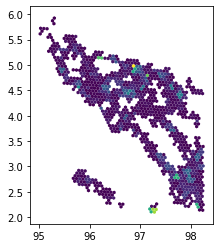

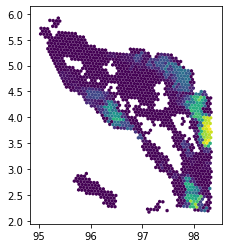

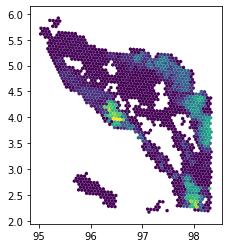

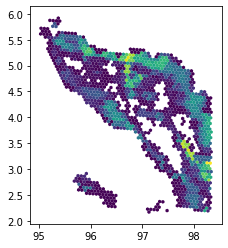

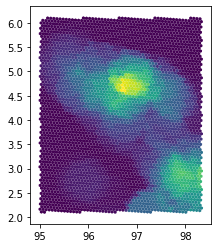

In [7]:
#translate density raster to h3
rp_density = '../../datasets/raw/methodology_results/Deforestation_IDN_2021-01-01-2022-01-01_density.tif'
rp_area = '../../datasets/processed/Satelligence_data/area_ratio/8_Areakm_clip_ind.tif'
rp_oil_prod_t = '../../datasets/raw/methodology_results/spam_palm_oil_prod_clip.tif'
rp_oil_ha = '../../datasets/raw/methodology_results/spam_palm_oil_ha_clip.tif'
rp_all_comm_ha = '../../datasets/raw/methodology_results/harvest_area_mapspam/harvest_area_sum_ha_clip.tif'
kernel_Def = '../../datasets/raw/methodology_results/update/deforestation_50km_kernel_v2.tif'


resolution = 6




gdf_def_density = raster_to_h3(rp_density, resolution=resolution, field ='def_density', plot=True)

# translate pixel area to h3 to compute pixel area/h3 area ratio
#translate density raster to h3
gdf_def_area = raster_to_h3(rp_area, resolution=resolution, field='pixel_area_km2')
gdf_po_prod = raster_to_h3(rp_oil_prod_t, resolution=resolution, field='prod_t', plot=True)
gdf_po_ha = raster_to_h3(rp_oil_ha, resolution=resolution, field='harvst_ha', plot=True)
gdf_allcommodities_ha = raster_to_h3(rp_all_comm_ha, resolution=resolution, field='harvst_all_ha', plot=True)
gdf_kernel_Def = raster_to_h3(kernel_Def, resolution=resolution, field='kernel_def_ha', plot=True)


## merge datasets

gdf_merge = gdf_po_prod.merge(gdf_po_ha, on='h3index', how='outer').merge(gdf_def_area, on='h3index', how='outer')[['h3index', 'pixel_area_km2', 'prod_t', 'harvst_ha', 'geometry']].merge(gdf_def_density, on='h3index', how='outer').merge(gdf_allcommodities_ha, on='h3index', how='outer')


#clean merged dataset - get just one geometry

gdf_merge = gdf_merge[['h3index','def_density', 'pixel_area_km2', 'prod_t', 'harvst_ha','harvst_all_ha','geometry_x']].rename(columns={'geometry_x':'geometry'})
gdf_merge = gdf_merge.merge(gdf_kernel_Def, on='h3index', how='outer')[['h3index','def_density', 'pixel_area_km2', 'prod_t', 'harvst_ha','harvst_all_ha','kernel_def_ha','geometry_x']].rename(columns={'geometry_x':'geometry'})

#calculate deforestation area 
gdf_merge['def_area_ha'] = gdf_merge['pixel_area_km2']*100*gdf_merge['def_density']
gdf_merge['h3index'] = [h3index.split('x')[1] for h3index in gdf_merge['h3index']]
gdf_merge['h3Area_km2'] = [h3.cell_area(h3index) for h3index in list(gdf_merge['h3index'])]
gdf_merge['area_ratio'] = gdf_merge['h3Area_km2']/gdf_merge['pixel_area_km2']

gdf_merge.head()

In [83]:
gdf_merge = gdf_merge.set_geometry('geometry')
gdf_merge.to_file('../../datasets/raw/methodology_results/update/gdf_kernel_Deforestation_v2.shp')

<ipython-input-83-afa81b12b667>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_merge.to_file('../../datasets/raw/methodology_results/update/gdf_kernel_Deforestation_v2.shp')


### 1. Point of production:

    -Example mill name: AGRA BUMI NIAGA
    -Gfw_id = 1873
    -Uml_id = PO1000010250
    -Lat, lon = 4.575718, 97.6190685
    -Country = Indonesia

#### Land impact:

land impact(ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))


forest loss (ha) = deforestation (ha/yr) * land impact (ha) /sum(harvest area) (ha)



In [8]:
point_location = gpd.read_file('../../datasets/raw/methodology_results/test_location_point.geojson')
point_location = point_location.h3.geo_to_h3(6).reset_index(drop=False)

point_location = point_location[['h3_06']]

point_location['geometry'] = Polygon(h3.h3_to_geo_boundary(point_location['h3_06'][0], geo_json=True))
point_location = point_location.set_geometry('geometry')
#point_location.to_file('../../datasets/raw/methodology_results/test_location_point_h3_res6_v3.shp')

point_location


,h3_06,geometry
0,866509697ffffff,"POLYGON ((97.63571 4.57267, 97.63863 4.60908, ..."


In [9]:
#obtain deforestation that takes places in that hexagon

h3index_list = list(point_location['h3_06'])

def_point_loc = gdf_merge[gdf_merge['h3index'].isin(h3index_list)]
def_point_loc


,h3index,def_density,pixel_area_km2,prod_t,harvst_ha,harvst_all_ha,kernel_def_ha,geometry,def_area_ha,h3Area_km2,area_ratio
121,866509697ffffff,0.006317,85.771797,14998.599609,947.200012,3014.800293,3.945905,"POLYGON ((97.63571 4.57267, 97.63863 4.60908, ...",54.183953,42.993477,0.501254


In [10]:
#asumming volume equal to 1T
land_impact_point = 1000*def_point_loc['harvst_ha'].sum()/def_point_loc['prod_t'].sum()
print(f'land impact: {land_impact_point} ha')

def_if = sum(def_point_loc['kernel_def_ha'] * def_point_loc['prod_t'])/ def_point_loc['prod_t'].sum()
print(f'Dif: {def_if}')

#Weighted mean total cropland area per pixel
def_total_cropland_area_per_pixel = (def_point_loc['harvst_all_ha'] * def_point_loc['prod_t']).dropna().sum() /def_point_loc['prod_t'].sum()
print(f'Mean cropland area: {def_total_cropland_area_per_pixel}')

def_impact_2 = (def_if * land_impact_point) / def_total_cropland_area_per_pixel
print(f'Revised forest loss risk:{def_impact_2} ha')

land impact: 63.15256336431409 ha
Dif: 3.945905105984504
Mean cropland area: 3014.80029296875
Revised forest loss risk:0.08265689200589445 ha


### 2. Aggergation point - 50km buffer:

    -Example mill name: AGRA BUMI NIAGA
    -Gfw_id = 1873
    -Uml_id = PO1000010250
    -Lat, lon = 4.575718, 97.6190685
    -Country = Indonesia

land impact(ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))

forest loss (ha) = deforestation (ha/yr) * land impact (ha) /sum(harvest area) (ha)

In [11]:
agg_point = gpd.read_file('../../datasets/raw/methodology_results/test_location_point.geojson')
agg_point = agg_point.to_crs('EPSG:3857')
agg_point = agg_point.buffer(50000)
agg_point = agg_point.to_crs('EPSG:4326')

h3_agg_point = h3.polyfill(agg_point.geometry[0].__geo_interface__, 6, geo_json_conformant = True)

agg_point_gdf = gpd.GeoDataFrame(h3_agg_point)
agg_point_gdf =  agg_point_gdf.rename(columns={0:'h3index'})
agg_point_gdf['geometry'] = [Polygon(h3.h3_to_geo_boundary(h3index,  geo_json=True)) for h3index in list(agg_point_gdf['h3index'])]
#agg_point_gdf.to_file('../../datasets/raw/methodology_results/test_agg_point_h3_res6_v2.shp')
agg_point_gdf.head()

,h3index,geometry
0,8665096dfffffff,"POLYGON ((97.40913 4.53505, 97.41202 4.57145, ..."
1,86650badfffffff,"POLYGON ((97.66197 4.90044, 97.66489 4.93688, ..."
2,866509457ffffff,"POLYGON ((97.87199 4.33491, 97.87493 4.37128, ..."
3,866556c1fffffff,"POLYGON ((97.33549 4.81544, 97.33838 4.85188, ..."
4,866556d2fffffff,"POLYGON ((97.44522 4.58724, 97.44812 4.62364, ..."


In [12]:
#obtain deforestation that takes places in that hexagon
h3index_list = list(agg_point_gdf['h3index'])

def_agg_loc = gdf_merge[gdf_merge['h3index'].isin(h3index_list)]
def_agg_loc.head()

,h3index,def_density,pixel_area_km2,prod_t,harvst_ha,harvst_all_ha,kernel_def_ha,geometry,def_area_ha,h3Area_km2,area_ratio
30,866509407ffffff,NaN,85.801598,23407.0,1525.0,5400.299805,2.709576,"POLYGON ((97.99883 4.32516, 98.00178 4.36152, ...",NaN,42.917517,0.500195
31,86650941fffffff,NaN,85.801598,23407.0,1525.0,5400.299805,2.674173,"POLYGON ((97.97155 4.38215, 97.97450 4.41852, ...",NaN,42.931822,0.500362
53,86650969fffffff,0.001056,85.771797,795.5,90.5,344.300018,4.196029,"POLYGON ((97.57222 4.57753, 97.57513 4.61394, ...",9.057337,42.997994,0.501307
54,86650ba6fffffff,0.000745,85.771797,795.5,90.5,344.300018,4.402756,"POLYGON ((97.60834 4.62971, 97.61125 4.66612, ...",6.389491,43.006872,0.501410
55,866556d37ffffff,0.000745,85.771797,795.5,90.5,344.300018,4.402756,"POLYGON ((97.54483 4.63457, 97.54774 4.67098, ...",6.389491,43.011312,0.501462


In [13]:
#asumming volume equal to 1T
land_impact_agg_point = 1000*def_agg_loc['harvst_ha'].sum()/def_agg_loc['prod_t'].sum()
print(f'land impact: {land_impact_agg_point} ha')

def_if = sum((def_agg_loc['kernel_def_ha'] * def_agg_loc['prod_t']).dropna()) /  def_agg_loc['prod_t'].sum()
print(f'Dif: {def_if}')

#Weighted mean total cropland area per pixel
def_total_cropland_area_per_pixel = (def_agg_loc['harvst_all_ha'] * def_agg_loc['prod_t']).dropna().sum() /def_agg_loc['prod_t'].sum()
print(f'Mean cropland area: {def_total_cropland_area_per_pixel}')

def_impact_agg_2 = (def_if * land_impact_agg_point) / def_total_cropland_area_per_pixel
print(f'Revised forest loss risk:{def_impact_agg_2} ha')


land impact: 71.72121424962671 ha
Dif: 3.1426641535365127
Mean cropland area: 3551.81494140625
Revised forest loss risk:0.06345929976328507 ha


In [15]:
## map - land impact aggregation point:
def_agg_loc['land_impact_ha'] = (def_agg_loc['prod_t']*land_impact_agg_point) / def_agg_loc['prod_t'].sum()
def_agg_loc['def_impact_ha'] = (def_agg_loc['prod_t']*def_impact_agg) / def_agg_loc['prod_t'].sum()
def_agg_loc = def_agg_loc.set_geometry('geometry')
#def_agg_loc.to_file('../../datasets/raw/methodology_results/update/agg_point_h3_res6_impact_v1_kernel.shp')

def_agg_loc.head()

<ipython-input-15-56cda87b5618>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_agg_loc['land_impact_ha'] = (def_agg_loc['prod_t']*land_impact_agg_point) / def_agg_loc['prod_t'].sum()


NameError: name 'def_impact_agg' is not defined

### 3. Admin area - Aceh:

land impact (ha) = volume(T) * sum(Harvest area (ha)) /sum( production (T))

forest loss (ha) = deforestation (ha/yr) * land impact (ha) /sum(harvest area) (ha)

In [102]:
adm_loc = gpd.read_file('../../datasets/raw/methodology_results/aceh_loc.geojson')
adm_loc = adm_loc.explode(index_parts=True)
h3_multipol = [h3.polyfill(geom.__geo_interface__, 6, geo_json_conformant = True) for geom in list(adm_loc['geometry'])]

for i in range(0,len(h3_multipol)):
    if i == 0:
        df_mult = pd.DataFrame(h3_multipol[i])
    else:
        
        df_ = pd.DataFrame(h3_multipol[i])
        df_mult = pd.concat([df_mult, df_])
df_mult =  df_mult.rename(columns={0:'h3index'})
df_mult['geometry'] = [Polygon(h3.h3_to_geo_boundary(h3index,  geo_json=True)) for h3index in list(df_mult['h3index'])]
df_mult = df_mult.set_geometry('geometry')
#df_mult.to_file('../../datasets/raw/methodology_results/test_aceh_h3_res6.shp')
df_mult.head()

,h3index,geometry
0,866573917ffffff,"POLYGON ((96.64380 2.07756, 96.64658 2.11362, ..."
1,86657064fffffff,"POLYGON ((96.70686 2.07286, 96.70965 2.10891, ..."
0,86657044fffffff,"POLYGON ((97.14820 2.03986, 97.15104 2.07590, ..."
0,8665739a7ffffff,"POLYGON ((96.67951 2.12930, 96.68230 2.16536, ..."
0,86657041fffffff,"POLYGON ((97.34587 2.13381, 97.34873 2.16987, ..."


In [103]:
#obtain deforestation that takes places in that hexagon
h3index_list = list(df_mult['h3index'])

def_aceh = gdf_merge[gdf_merge['h3index'].isin(h3index_list)]
def_aceh.head()

,h3index,def_density,pixel_area_km2,prod_t,harvst_ha,harvst_all_ha,kernel_def_ha,geometry,def_area_ha,h3Area_km2,area_ratio
0,866550017ffffff,0.007334,85.781898,1963.099976,378.700012,1524.099854,2.878644,"POLYGON ((95.81241 4.54512, 95.81512 4.58153, ...",62.915216,43.026066,0.501575
1,866550037ffffff,0.000570,85.781898,1963.099976,378.700012,1524.099854,2.631647,"POLYGON ((95.84010 4.48815, 95.84282 4.52456, ...",4.886686,43.014405,0.501439
2,866550d0fffffff,0.000126,85.801598,8304.400391,336.299988,1782.599976,4.385420,"POLYGON ((96.27655 4.34589, 96.27932 4.38229, ...",1.080853,42.985871,0.500991
3,866550d57ffffff,0.000126,85.801598,8304.400391,336.299988,1782.599976,4.385420,"POLYGON ((96.21304 4.35063, 96.21580 4.38702, ...",1.080853,42.987059,0.501005
4,86655609fffffff,0.000406,85.718300,2457.500000,404.200012,1979.599854,6.147684,"POLYGON ((96.93507 5.01085, 96.93791 5.04732, ...",3.479367,43.111419,0.502943


In [110]:
#asumming volume equal to 1T
land_impact_aceh = 1000*def_aceh['harvst_ha'].sum()/def_aceh['prod_t'].sum()
print(f'land impact: {land_impact_aceh} ha')

def_if = (def_aceh['kernel_def_ha'] * def_aceh['prod_t']).dropna().sum() /def_aceh['prod_t'].sum()
print(f'Dif: {def_if}')

#Weighted mean total cropland area per pixel
def_total_cropland_area_per_pixel = (def_aceh['harvst_all_ha'] * def_aceh['prod_t']).dropna().sum() /def_aceh['prod_t'].sum()
print(f'Mean cropland area: {def_total_cropland_area_per_pixel}')

def_impact_aceh_2 = (def_if * land_impact_aceh) / def_total_cropland_area_per_pixel
print(f'Revised forest loss risk:{def_impact_aceh_2} ha')


land impact: 87.19526554714088 ha
Dif: 3.761295795440674
Forest loss risk:0.00013937714945840143 ha


In [111]:
def_aceh['land_impact_ha'] = (def_aceh['prod_t']*land_impact_aceh) / def_aceh['prod_t'].sum()
def_aceh['def_impact_ha'] = (def_aceh['prod_t']*def_impact_aceh) / def_aceh['prod_t'].sum()
def_aceh = def_aceh.set_geometry('geometry')
def_aceh.to_file('../../datasets/raw/methodology_results/update/Aceh_h3_res6_impact_v1_kernel.shp')

def_aceh.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-111-31b9ad4911aa>:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  def_aceh.to_file('../../datasets/raw/methodology_results/update/Aceh_h3_res6_impact_v1_kernel.shp')


,h3index,def_density,pixel_area_km2,prod_t,harvst_ha,harvst_all_ha,kernel_def_ha,geometry,def_area_ha,h3Area_km2,area_ratio,land_impact_ha,def_impact_ha
0,866550017ffffff,0.007334,85.781898,1963.099976,378.700012,1524.099854,2.878644,"POLYGON ((95.81241 4.54512, 95.81512 4.58153, ...",62.915216,43.026066,0.501575,0.033599,5.370679e-08
1,866550037ffffff,0.000570,85.781898,1963.099976,378.700012,1524.099854,2.631647,"POLYGON ((95.84010 4.48815, 95.84282 4.52456, ...",4.886686,43.014405,0.501439,0.033599,5.370679e-08
2,866550d0fffffff,0.000126,85.801598,8304.400391,336.299988,1782.599976,4.385420,"POLYGON ((96.27655 4.34589, 96.27932 4.38229, ...",1.080853,42.985871,0.500991,0.142133,2.271931e-07
3,866550d57ffffff,0.000126,85.801598,8304.400391,336.299988,1782.599976,4.385420,"POLYGON ((96.21304 4.35063, 96.21580 4.38702, ...",1.080853,42.987059,0.501005,0.142133,2.271931e-07
4,86655609fffffff,0.000406,85.718300,2457.500000,404.200012,1979.599854,6.147684,"POLYGON ((96.93507 5.01085, 96.93791 5.04732, ...",3.479367,43.111419,0.502943,0.042061,6.723266e-08
